In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_by_feature_extraction(df, models, metric='AUC', show_eval=True, show_train=True, show_random=False, compare_models=(), tag="", maximise_metric=True):
    df['Feature_extraction_method'] = df['search_term'].apply(lambda x: x.split('_', 1)[1])
    df["Feature_extraction_method"] = df["Feature_extraction_method"].apply(lambda x: "_".join(x.split("_")[:-2]))
    df["Feature_extraction_method"].unique()
    
    if maximise_metric:
        best_model_train_score = 0
        best_model_eval_score = 0
    else:
        best_model_train_score = np.inf
        best_model_eval_score = np.inf
    best_train_search_term = ""
    best_eval_search_term = ""
    feature_extraction_methods = df['Feature_extraction_method'].unique()

    # Define a color palette for models
    color_palette = sns.color_palette('tab10', len(models))
    model_colors = dict(zip(models, color_palette))

    for method in feature_extraction_methods:
        method_df = df[df['Feature_extraction_method'] == method]
        
        grouped_method_df = method_df.groupby(
            ["percentage_of_data", "model_type", "eval_or_train", "search_term"]
        )[[metric]].mean().reset_index()

        plt.figure(figsize=(12, 6))
        grouped_method_df_train = grouped_method_df[grouped_method_df["eval_or_train"] == "train"]
        grouped_method_df_eval = grouped_method_df[grouped_method_df["eval_or_train"] == "eval"]

        for model in models:
            if not show_random and model == 'Random':
                continue

            train_data = grouped_method_df_train[grouped_method_df_train['model_type'] == model]
            eval_data = grouped_method_df_eval[grouped_method_df_eval['model_type'] == model]
            color = model_colors[model]
            if show_train:
                plt.plot(train_data['percentage_of_data'], train_data[metric], label=f'{model} (train)', linestyle='-', color=color)
            if show_eval:
                plt.plot(eval_data['percentage_of_data'], eval_data[metric], label=f'{model} (eval)', linestyle='--', color=color)
            if maximise_metric:
                if not train_data.empty and train_data[metric].max() > best_model_train_score:
                    best_model_train_score = train_data[metric].max()
                    best_train_search_term = train_data[train_data[metric] == best_model_train_score].iloc[0]['search_term']
                if not eval_data.empty and eval_data[metric].max() > best_model_eval_score:
                    best_model_eval_score = eval_data[metric].max()
                    best_eval_search_term = eval_data[eval_data[metric] == best_model_eval_score].iloc[0]['search_term']
            else:
                if not train_data.empty and train_data[metric].min() < best_model_train_score:
                    best_model_train_score = train_data[metric].min()
                    best_train_search_term = train_data[train_data[metric] == best_model_train_score].iloc[0]['search_term']
                if not eval_data.empty and eval_data[metric].min() < best_model_eval_score:
                    best_model_eval_score = eval_data[metric].min()
                    best_eval_search_term = eval_data[eval_data[metric] == best_model_eval_score].iloc[0]['search_term']

        plt.xlabel('Percentage of Data')
        plt.ylabel(f'Mean {metric.replace("_", " ")}')
        plt.title(f'{tag}: {metric.replace("_", " ")} vs Percentage of Data by Model - Feature Extraction: {method}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

        # If model comparison is defined, create a difference plot
        if compare_models:
            model1, model2 = compare_models
            if show_eval:
                data_model1 = grouped_method_df_eval[grouped_method_df_eval['model_type'] == model1]
                data_model2 = grouped_method_df_eval[grouped_method_df_eval['model_type'] == model2]

                if not data_model1.empty and not data_model2.empty:
                    diff_data = data_model1.merge(data_model2, on='percentage_of_data', suffixes=('_1', '_2'))
                    diff_data['metric_difference'] = diff_data[f'{metric}_1'] - diff_data[f'{metric}_2']

                    plt.figure(figsize=(10, 5))
                    plt.plot(diff_data['percentage_of_data'], diff_data['metric_difference'], marker='o', linestyle='-', color='red')
                    plt.xlabel('Percentage of Data')
                    plt.ylabel(f'Difference in {metric.replace("_", " ")}')
                    plt.title(f'Difference in EVAL {metric.replace("_", " ")} between {model1} and {model2} - Feature Extraction: {method}')
                    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
                    plt.grid(True)
                    plt.show()
            if show_train:
                data_model1 = grouped_method_df_train[grouped_method_df_train['model_type'] == model1]
                data_model2 = grouped_method_df_train[grouped_method_df_train['model_type'] == model2]

                if not data_model1.empty and not data_model2.empty:
                    diff_data = data_model1.merge(data_model2, on='percentage_of_data', suffixes=('_1', '_2'))
                    diff_data['metric_difference'] = diff_data[f'{metric}_1'] - diff_data[f'{metric}_2']

                    plt.figure(figsize=(10, 5))
                    plt.plot(diff_data['percentage_of_data'], diff_data['metric_difference'], marker='o', linestyle='-', color='red')
                    plt.xlabel('Percentage of Data')
                    plt.ylabel(f'Difference in {metric.replace("_", " ")}')
                    plt.title(f'Difference in TRAIN {metric.replace("_", " ")} between {model1} and {model2} - Feature Extraction: {method}')
                    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
                    plt.grid(True)
                    plt.show()

    print(f"Best model train score: {best_model_train_score} with search term: {best_train_search_term}")
    print(f"Best model eval score: {best_model_eval_score} with search term: {best_eval_search_term}")


In [18]:
#path = "00_results/age_ausgeglichen_10_classes/"
tag = "normative/experiment_1_wm"
path = f"./00_results/{tag}/"
csvs_deconfounded = [path + f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(file) for file in csvs_deconfounded])

In [19]:
df

,label_col,mri_table,test_set_size,Feature_extraction_applied,Pretraining_applied,model_type,mse,mae,r2,pearson,number_of_cross_validations,cross_validation_count,search_term,percentage_of_data,eval_or_train
0,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,95.00% (approx. of data left for test),False,False,Random,162.7800,10.3400,-1.685146,0.001569,5,0,0.05_Nothing_Random_train,0.05,train
1,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,95.00% (approx. of data left for test),False,False,Random,153.4160,10.2280,-1.669007,0.043914,5,0,0.05_Nothing_Random_eval,0.05,eval
2,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,95.00% (approx. of data left for test),False,False,Random,123.2500,9.2100,-1.183538,0.120181,5,1,0.05_Nothing_Random_train,0.05,train
3,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,95.00% (approx. of data left for test),False,False,Random,139.2290,9.6130,-1.422193,-0.009241,5,1,0.05_Nothing_Random_eval,0.05,eval
4,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,95.00% (approx. of data left for test),False,False,Random,114.8300,8.7300,-1.319447,-0.077426,5,2,0.05_Nothing_Random_train,0.05,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,0.00% (approx. of data left for test),False,False,LGBM,27.4670,4.1470,0.522151,0.723672,5,2,1.0_Nothing_LGBM_eval,1.00,eval
236,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,0.00% (approx. of data left for test),False,False,LGBM,26.8100,4.1410,0.525628,0.726291,5,3,1.0_Nothing_LGBM_train,1.00,train
237,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,0.00% (approx. of data left for test),False,False,LGBM,27.6390,4.1590,0.519159,0.721429,5,3,1.0_Nothing_LGBM_eval,1.00,eval
238,age_at_assessment,aparc.thickness_aparc.volume_aseg.volume.csv,0.00% (approx. of data left for test),False,False,LGBM,25.8785,4.0715,0.530360,0.729599,5,4,1.0_Nothing_LGBM_train,1.00,train


In [20]:
df['Feature_extraction_method'] = df['search_term'].apply(lambda x: x.split('_', 1)[1])
df["Feature_extraction_method"] = df["Feature_extraction_method"].apply(lambda x: "_".join(x.split("_")[:-2]))
df["Feature_extraction_method"].unique()

array(['Nothing'], dtype=object)

In [21]:
models = df['model_type'].unique()

In [22]:
models

array(['Random', 'tabpfn', 'MLP', 'CNN', 'LGBM'], dtype=object)

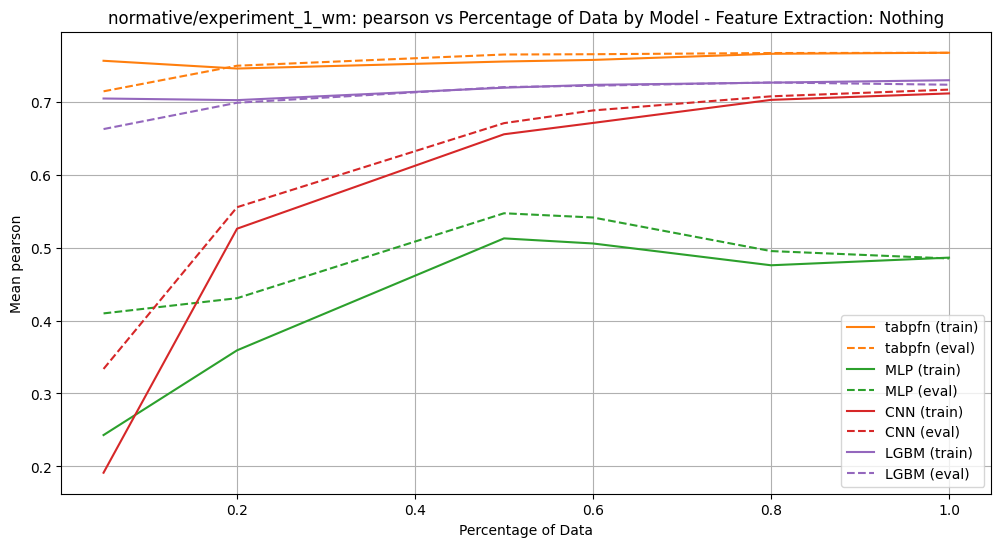

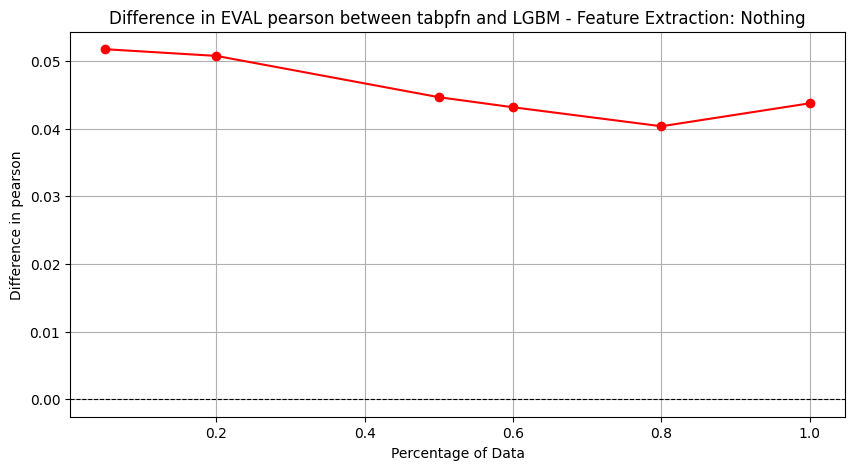

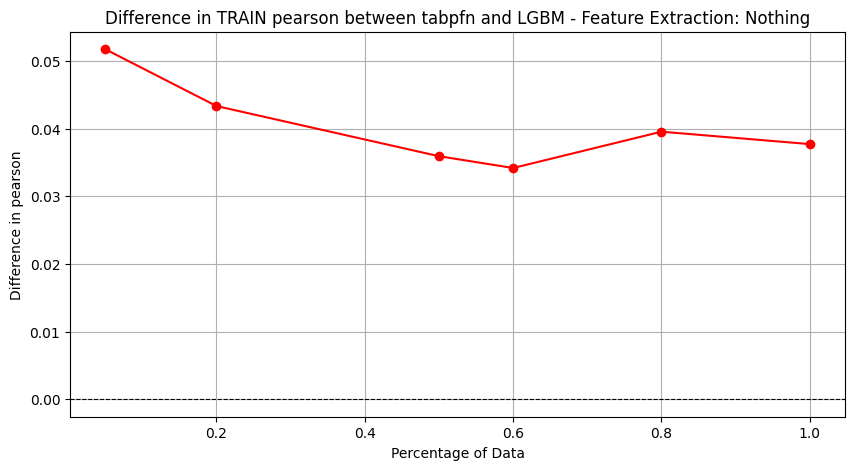

Best model train score: 0.7671188326105958 with search term: 1.0_Nothing_tabpfn_train
Best model eval score: 0.766991331598836 with search term: 1.0_Nothing_tabpfn_eval


In [23]:

plot_metric_by_feature_extraction(df, models, metric='pearson', show_eval=True, compare_models=("tabpfn", "LGBM"), tag=tag)

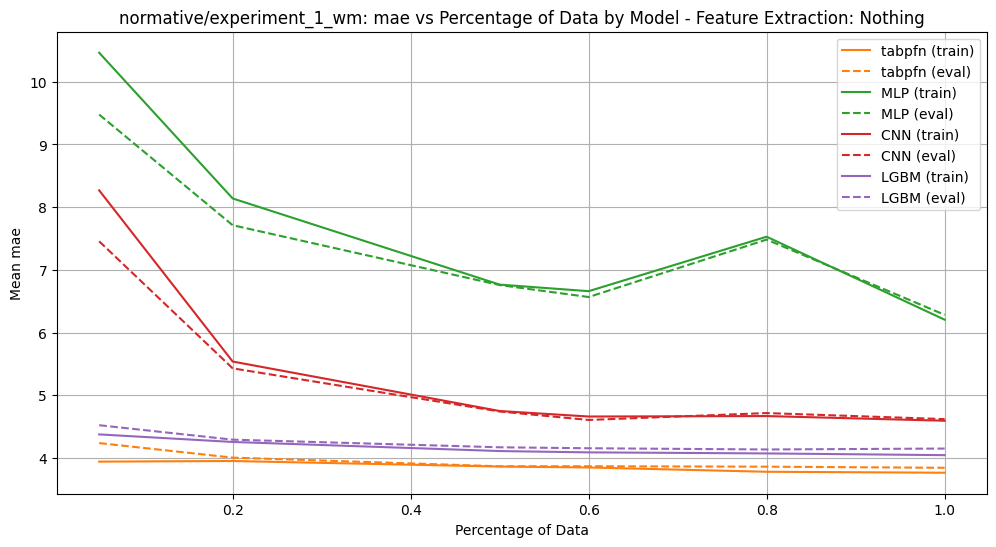

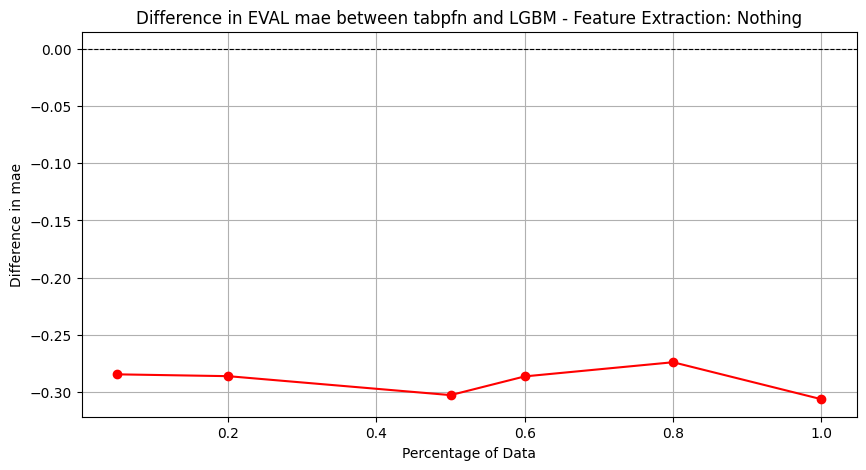

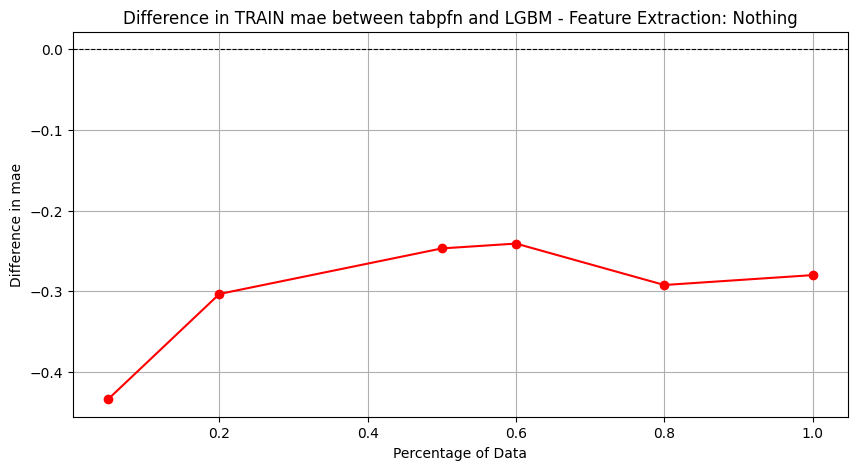

Best model train score: 3.7672 with search term: 1.0_Nothing_tabpfn_train
Best model eval score: 3.8457999999999997 with search term: 1.0_Nothing_tabpfn_eval


In [24]:
plot_metric_by_feature_extraction(df, models, metric='mae', show_eval=True, compare_models=("tabpfn", "LGBM"), tag=tag, maximise_metric=False)

In [25]:
import pandas as pd
import os

# Define the directory containing the CSV files
csv_directory = "/home/esralenz/Dokumente/20_HITKIP/03_UKB/00_Git_Code/TABPFN/03_analyse_results/00_results/normative/experiment_1_wm/predictions_normative"

# Define file groups by their keywords
file_groups = ["bad_wm", "good_wm", "control", "test", "result_baseline"]
df_dict = {}

# Load and analyze the corresponding files for each keyword
for group in file_groups:
    # Find all matching files for the current group
    group_files = [f for f in os.listdir(csv_directory) if group in f and f.endswith(".csv")]

    # If there are multiple versions, load the latest based on timestamp
    if group_files:
        group_files.sort()  # Assumes filenames are sortable by timestamp
        latest_file = group_files[-1]

        # Load the CSV file
        file_path = os.path.join(csv_directory, latest_file)
        df = pd.read_csv(file_path)


        # Store the DataFrame in a dictionary for later use
        df_dict[group] = df
        # Example analysis (modify as needed)
        print(f"Analysis for {group} from file {latest_file}:")
        print(df.describe())  # You can replace this with your analysis logic

    else:
        print(f"No files found for group '{group}'.")

# Define the directory containing the CSV files
csv_directory = "/home/esralenz/Dokumente/20_HITKIP/03_UKB/00_Git_Code/TABPFN/03_analyse_results/00_results/normative/experiment_1_wm/predictions_normative/tabpfn"

# Define file groups by their keywords
file_groups = ["bad_wm", "good_wm", "control", "test", "result_baseline"]
df_dict_2 = {}

# Load and analyze the corresponding files for each keyword
for group in file_groups:
    # Find all matching files for the current group
    group_files = [f for f in os.listdir(csv_directory) if group in f and f.endswith(".csv")]

    # If there are multiple versions, load the latest based on timestamp
    if group_files:
        group_files.sort()  # Assumes filenames are sortable by timestamp
        latest_file = group_files[-1]

        # Load the CSV file
        file_path = os.path.join(csv_directory, latest_file)
        df = pd.read_csv(file_path)


        # Store the DataFrame in a dictionary for later use
        df_dict_2[group] = df
        # Example analysis (modify as needed)
        print(f"Analysis for {group} from file {latest_file}:")
        print(df.describe())  # You can replace this with your analysis logic

    else:
        print(f"No files found for group '{group}'.")

Analysis for bad_wm from file 2025-02-03_23-32-39_bad_wm_predicted.csv:
                 ID  assessment_centre         bmi  deprivation_index  \
count  1.650000e+02         165.000000  165.000000          165.00000   
mean   3.561782e+06           1.036364   27.050208           -1.19600   
std    1.409445e+06           0.810683    4.923363            3.24984   
min    1.053031e+06           0.000000   16.598300           -6.08000   
25%    2.360988e+06           0.000000   23.922400           -3.69000   
50%    3.478829e+06           1.000000   26.103500           -2.22000   
75%    4.799544e+06           2.000000   29.721300            0.73000   
max    5.957955e+06           3.000000   42.539000            7.10000   

       age_at_assessment    sex  label_nd_vs_no_nd_sex_balanced  \
count         165.000000  165.0                        7.000000   
mean           67.612121    0.0                        0.571429   
std             7.899203    0.0                        0.534522   
mi

In [26]:
df

,Unnamed: 0,ID,fold,model,real_outcome,predicted_outcome,percentage,deconfounding
0,0,5152072,1,Random,61,77.000000,0.05,Nothing
1,1,3906705,1,Random,52,62.000000,0.05,Nothing
2,2,4186036,1,Random,52,50.000000,0.05,Nothing
3,3,2356904,1,Random,46,48.000000,0.05,Nothing
4,4,5446224,1,Random,51,56.000000,0.05,Nothing
...,...,...,...,...,...,...,...,...
62995,62995,5763116,5,tabpfn,51,54.882278,1.00,Nothing
62996,62996,4857523,5,tabpfn,66,65.728210,1.00,Nothing
62997,62997,5766788,5,tabpfn,63,67.908203,1.00,Nothing
62998,62998,2624233,5,tabpfn,68,66.476303,1.00,Nothing


In [27]:
def analyse_results(df, name, drop_random=True):
    print(f"Analysis for {name}:")
    print(df.describe())
    print(df.head())
    if drop_random:
        df = df[df["model"] != "Random"]
    df["error"] = df["predicted_outcome"] - df["real_outcome"]
    mean_error_by_model = df.groupby('model')['error'].mean()
    print(mean_error_by_model)

In [28]:
def analyse_results(df, name, drop_random=True):
    print(f"Analysis for {name}:")
    display(df.describe())
    df["error"] = df["predicted_age"] - df["age_at_assessment"]
    #just get the mean, there i no group
    mean_error_by_model = df['error'].mean()
    print(mean_error_by_model)

In [29]:
analyse_results(df_dict["bad_wm"], "bad_wm")

Analysis for bad_wm:


,ID,assessment_centre,bmi,deprivation_index,age_at_assessment,sex,label_nd_vs_no_nd_sex_balanced,label_no_nd_dep_vs_nd_dep_sex_balanced,label_nd_no_dep_vs_nd_dep_sex_balanced,label_no_nd_no_dd_vs_nd_dd_sex_balanced,...,label_HRD_Binge>1_frequ>2_no_ol,label_HRD_Binge>3_frequ>3_no_ol,label_HRD_Binge>2_frequ>3_no_ol,label_HRD_Binge>1_frequ>3_no_ol,label_double_depressed,label_Probably Depressed,label_severely_depressed,label_Bad_WM_Memory,label_sick,predicted_age
count,1.650000e+02,165.000000,165.000000,165.00000,165.000000,165.0,7.000000,5.000000,2.0,0.0,...,162.000000,162.0,162.000000,162.000000,49.000000,81.000000,81.000000,165.0,165.0,165.000000
mean,3.561782e+06,1.036364,27.050208,-1.19600,67.612121,0.0,0.571429,0.400000,1.0,NaN,...,0.012346,0.0,0.012346,0.012346,0.061224,0.246914,0.333333,1.0,1.0,63.782411
std,1.409445e+06,0.810683,4.923363,3.24984,7.899203,0.0,0.534522,0.547723,0.0,NaN,...,0.110766,0.0,0.110766,0.110766,0.242226,0.433903,0.474342,0.0,0.0,5.555540
min,1.053031e+06,0.000000,16.598300,-6.08000,49.000000,0.0,0.000000,0.000000,1.0,NaN,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,51.978111
25%,2.360988e+06,0.000000,23.922400,-3.69000,61.000000,0.0,0.000000,0.000000,1.0,NaN,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,58.991986
50%,3.478829e+06,1.000000,26.103500,-2.22000,70.000000,0.0,1.000000,0.000000,1.0,NaN,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,63.493283
75%,4.799544e+06,2.000000,29.721300,0.73000,74.000000,0.0,1.000000,1.000000,1.0,NaN,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,68.608999
max,5.957955e+06,3.000000,42.539000,7.10000,81.000000,0.0,1.000000,1.000000,1.0,NaN,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,75.347833


-3.8297103901122242


In [30]:
analyse_results(df_dict["good_wm"], "good_wm")

Analysis for good_wm:


,ID,assessment_centre,bmi,deprivation_index,age_at_assessment,sex,label_nd_vs_no_nd_sex_balanced,label_no_nd_dep_vs_nd_dep_sex_balanced,label_nd_no_dep_vs_nd_dep_sex_balanced,label_no_nd_no_dd_vs_nd_dd_sex_balanced,...,label_HRD_Binge>1_frequ>2_no_ol,label_HRD_Binge>3_frequ>3_no_ol,label_HRD_Binge>2_frequ>3_no_ol,label_HRD_Binge>1_frequ>3_no_ol,label_double_depressed,label_Probably Depressed,label_severely_depressed,label_Bad_WM_Memory,label_sick,predicted_age
count,1.650000e+02,165.000000,165.000000,165.000000,165.000000,165.0,8.0,0.0,0.0,1.0,...,159.0,159.0,159.0,159.0,61.0,61.0,61.0,165.0,165.0,165.000000
mean,1.799402e+06,1.042424,26.769972,-1.241636,67.527273,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.923060
std,9.611878e+05,0.783609,4.589680,3.192858,7.882958,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.367239
min,1.001446e+06,0.000000,16.015600,-5.550000,50.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.304752
25%,1.166457e+06,0.000000,23.706700,-3.770000,61.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.243328
50%,1.396324e+06,1.000000,25.728700,-2.320000,69.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.348422
75%,2.064518e+06,2.000000,28.793000,0.770000,74.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.328029
max,5.382969e+06,2.000000,43.555400,7.060000,80.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.852519


-4.604212968191677


In [36]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
def compare_two_df_wm(df1, df2, name1, name2):
    print(f"Comparison of {name1} and {name2}:")
    df1['error'] = df1['predicted_age'] - df1['age_at_assessment']
    df2['error'] = df2['predicted_age'] - df2['age_at_assessment']
    mean_error_df1 = df1['error'].mean()
    std_error_df1 = df1['error'].std()
    mean_error_df2 = df2['error'].mean()
    std_error_df2 = df2['error'].std()

    print(f"Group 1: {name1} Mean Error = {mean_error_df1:.2f}, Std = {std_error_df1:.2f}")
    print(f"Group 2: {name2} Mean Error = {mean_error_df2:.2f}, Std = {std_error_df2:.2f}")

    plt.hist(df1['error'], alpha=0.5, label=name1)
    plt.hist(df2['error'], alpha=0.5, label=name2)
    plt.xlabel("Error (Predicted - Real)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Error Distribution by Group")
    plt.show()

    # Boxplot
    data_to_plot = [df1['error'], df2['error']]
    plt.boxplot(data_to_plot, labels=[name1, name2])
    plt.ylabel("Error (Predicted - Real)")
    plt.title("Error Distribution by Group")
    plt.show()

    t_stat, p_val = ttest_ind(df1['error'], df2['error'], equal_var=False)  # use equal_var=False if variances differ
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

Comparison of bad_wm and good_wm:
Group 1: bad_wm Mean Error = -3.83, Std = 9.87
Group 2: good_wm Mean Error = -4.60, Std = 10.30


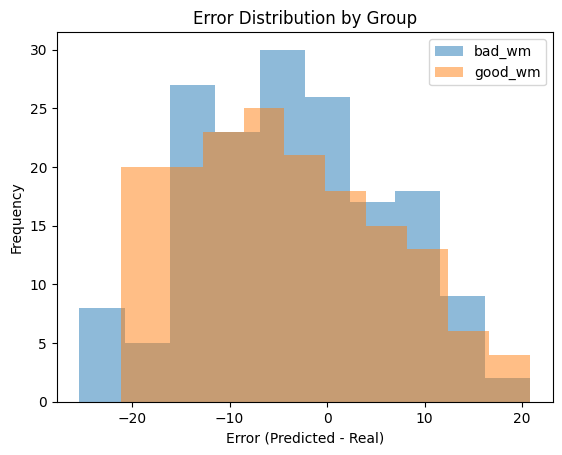

/tmp/ipykernel_3239553/3915986944.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[name1, name2])


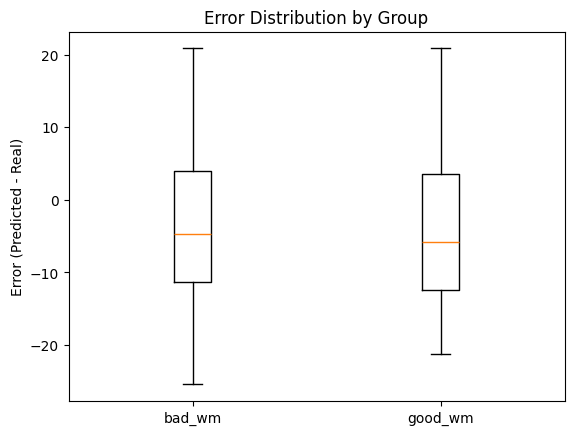

t-statistic: 0.697, p-value: 0.486


In [37]:
compare_two_df_wm(df_dict["bad_wm"], df_dict["good_wm"], "bad_wm", "good_wm")

In [38]:
analyse_results(df_dict_2["bad_wm"], "bad_wm")

Analysis for bad_wm:


,ID,assessment_centre,bmi,deprivation_index,age_at_assessment,sex,label_nd_vs_no_nd_sex_balanced,label_no_nd_dep_vs_nd_dep_sex_balanced,label_nd_no_dep_vs_nd_dep_sex_balanced,label_no_nd_no_dd_vs_nd_dd_sex_balanced,...,label_HRD_Binge>3_frequ>3_no_ol,label_HRD_Binge>2_frequ>3_no_ol,label_HRD_Binge>1_frequ>3_no_ol,label_double_depressed,label_Probably Depressed,label_severely_depressed,label_Bad_WM_Memory,label_sick,predicted_age,error
count,1.650000e+02,165.000000,165.000000,165.00000,165.000000,165.0,7.000000,5.000000,2.0,0.0,...,162.0,162.000000,162.000000,49.000000,81.000000,81.000000,165.0,165.0,165.000000,165.000000
mean,3.561782e+06,1.036364,27.050208,-1.19600,67.612121,0.0,0.571429,0.400000,1.0,NaN,...,0.0,0.012346,0.012346,0.061224,0.246914,0.333333,1.0,1.0,63.991901,-3.620220
std,1.409445e+06,0.810683,4.923363,3.24984,7.899203,0.0,0.534522,0.547723,0.0,NaN,...,0.0,0.110766,0.110766,0.242226,0.433903,0.474342,0.0,0.0,5.973978,10.159011
min,1.053031e+06,0.000000,16.598300,-6.08000,49.000000,0.0,0.000000,0.000000,1.0,NaN,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,51.532430,-26.200115
25%,2.360988e+06,0.000000,23.922400,-3.69000,61.000000,0.0,0.000000,0.000000,1.0,NaN,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,58.976600,-11.593765
50%,3.478829e+06,1.000000,26.103500,-2.22000,70.000000,0.0,1.000000,0.000000,1.0,NaN,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,64.385025,-3.476105
75%,4.799544e+06,2.000000,29.721300,0.73000,74.000000,0.0,1.000000,1.000000,1.0,NaN,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,68.837750,3.905228
max,5.957955e+06,3.000000,42.539000,7.10000,81.000000,0.0,1.000000,1.000000,1.0,NaN,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,76.390610,17.260345


-3.6202201515151513


In [39]:
analyse_results(df_dict_2["good_wm"], "good_wm")

Analysis for good_wm:


,ID,assessment_centre,bmi,deprivation_index,age_at_assessment,sex,label_nd_vs_no_nd_sex_balanced,label_no_nd_dep_vs_nd_dep_sex_balanced,label_nd_no_dep_vs_nd_dep_sex_balanced,label_no_nd_no_dd_vs_nd_dd_sex_balanced,...,label_HRD_Binge>3_frequ>3_no_ol,label_HRD_Binge>2_frequ>3_no_ol,label_HRD_Binge>1_frequ>3_no_ol,label_double_depressed,label_Probably Depressed,label_severely_depressed,label_Bad_WM_Memory,label_sick,predicted_age,error
count,1.650000e+02,165.000000,165.000000,165.000000,165.000000,165.0,8.0,0.0,0.0,1.0,...,159.0,159.0,159.0,61.0,61.0,61.0,165.0,165.0,165.000000,165.000000
mean,1.799402e+06,1.042424,26.769972,-1.241636,67.527273,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.204860,-4.322412
std,9.611878e+05,0.783609,4.589680,3.192858,7.882958,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.999163,10.649987
min,1.001446e+06,0.000000,16.015600,-5.550000,50.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.743270,-22.198547
25%,1.166457e+06,0.000000,23.706700,-3.770000,61.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.153046,-12.541640
50%,1.396324e+06,1.000000,25.728700,-2.320000,69.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.334717,-5.588690
75%,2.064518e+06,2.000000,28.793000,0.770000,74.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.244980,3.218605
max,5.382969e+06,2.000000,43.555400,7.060000,80.000000,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.707510,21.707510


-4.322412406060606


Comparison of bad_wm and good_wm:
Group 1: bad_wm Mean Error = -3.62, Std = 10.16
Group 2: good_wm Mean Error = -4.32, Std = 10.65


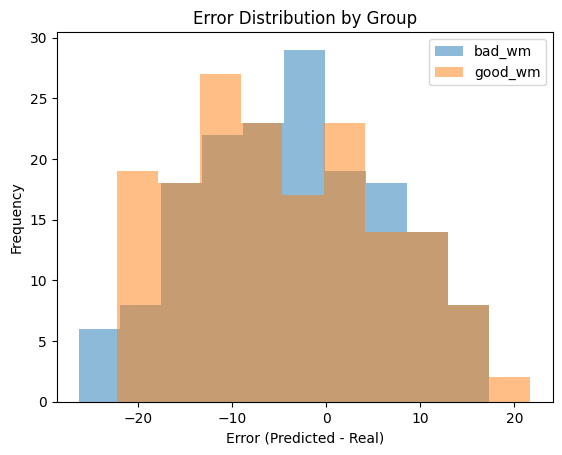

/tmp/ipykernel_3239553/3915986944.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=[name1, name2])


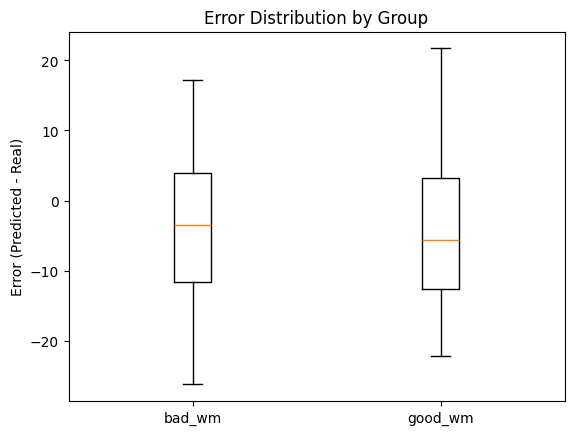

t-statistic: 0.613, p-value: 0.540


In [40]:
compare_two_df_wm(df_dict_2["bad_wm"], df_dict_2["good_wm"], "bad_wm", "good_wm")

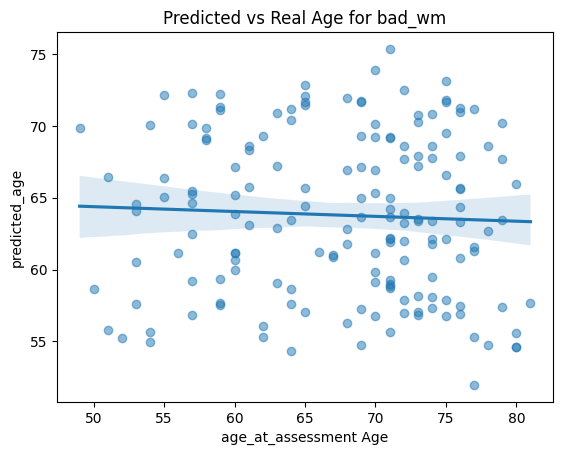

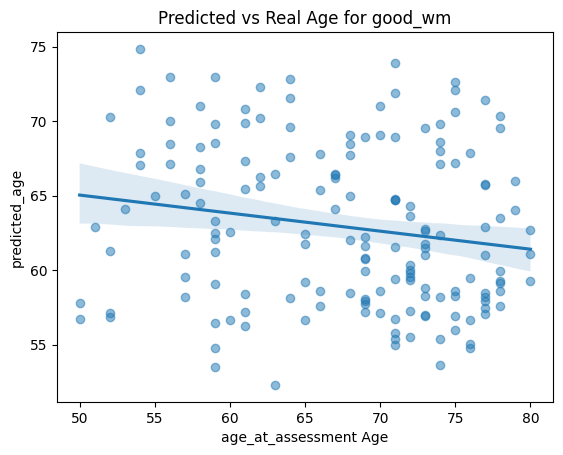

In [44]:
def plot_predicted_vs_real_seaborn(df, name):
    sns.regplot(x="age_at_assessment", y='predicted_age', data=df, scatter_kws={'alpha':0.5})
    plt.xlabel("age_at_assessment Age")
    plt.ylabel("predicted_age")
    plt.title(f"Predicted vs Real Age for {name}")
    plt.show()

plot_predicted_vs_real_seaborn(df_dict["bad_wm"], "bad_wm")
plot_predicted_vs_real_seaborn(df_dict["good_wm"], "good_wm")
